In [34]:
import pandas as pd
import numpy as np

import duckdb
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
def connect_db(path: str):
    '''Runs duckdb.connect() function on database path with timing. Returns a 
duckdb.DuckDBPyConnection object'''
    
    st = time.time()

    print('Connecting to database...')
    con = duckdb.connect(path)

    et = time.time()
    elapsed_time = et - st
    print(f'Connection established! Execution time: {elapsed_time} seconds')
    return con

def get_sample_size(taxa_pairs, ogt_diff):
    cmd = f"""SELECT COUNT(prot_pair_index) FROM protein_pairs WHERE taxa_pair_index IN
    (SELECT taxa_pair_index FROM {taxa_pairs} WHERE (thermo_ogt - meso_ogt >= {ogt_diff}))"""
    return con.execute(cmd).df().values

In [36]:
con = connect_db('/mnt/c/Users/Ryan/Documents/database')

Connecting to database...
Connection established! Execution time: 18.168161392211914 seconds


### Protein pair sampling space is significantly affected by $\Delta$ogt

This notebook investigates whether pairs in protein_pairs from the learn2therm dataset belong to thermo/meso pairs with very small differences in optimal growth temperature. For example, bacteria growing at 37 C vs 42 C would be considered a pair.

In [45]:
add_ogt_cmd = f"""CREATE OR REPLACE TABLE ogt_taxa_pairs AS SELECT *,
taxa_m.ogt AS meso_ogt,
taxa_t.ogt AS thermo_ogt,
taxa_t.ogt - taxa_m.ogt AS ogt_diff
FROM taxa_pairs
JOIN taxa AS taxa_m ON (taxa_pairs.meso_index = taxa_m.taxa_index)
JOIN taxa AS taxa_t ON (taxa_pairs.thermo_index = taxa_t.taxa_index)
WHERE taxa_pairs.is_pair = True"""

con.execute(add_ogt_cmd)

In [47]:
print(f'Relevant taxa pairs: {con.execute("""SELECT COUNT(taxa_pair_index) FROM ogt_taxa_pairs""").df().values}')

Relevant taxa pairs: [[13784]]


These 13784 are the 'true' taxa pairs based on the value of is_true. All others should not be represented in protein_pairs.

In [103]:
ogt_diffs = [0, 2, 5, 10, 15, 20, 25, 30, 40, 50, 55, 60]
num_pairs = []

for val in ogt_diffs:
    num_pairs.append(get_sample_size('ogt_taxa_pairs', val))

num_pairs = [int(i) for i in num_pairs]

print('Percentage remaining for ogt_diff cutoff:')
for i, n in enumerate(num_pairs):
    perc = n*100/181500502
    print(f'{ogt_diffs[i]} deg C: {round(perc, 2)} or {n} pairs')

Percentage remaining for ogt_diff cutoff:
0 deg C: 100.0 or 181500502 pairs
2 deg C: 99.9 or 181310321 pairs
5 deg C: 98.83 or 179370579 pairs
10 deg C: 90.97 or 165106546 pairs
15 deg C: 68.02 or 123451370 pairs
20 deg C: 29.67 or 53845080 pairs
25 deg C: 7.36 or 13361629 pairs
30 deg C: 2.39 or 4340704 pairs
40 deg C: 0.21 or 382187 pairs
50 deg C: 0.03 or 48870 pairs
55 deg C: 0.0 or 4189 pairs
60 deg C: 0.0 or 0 pairs


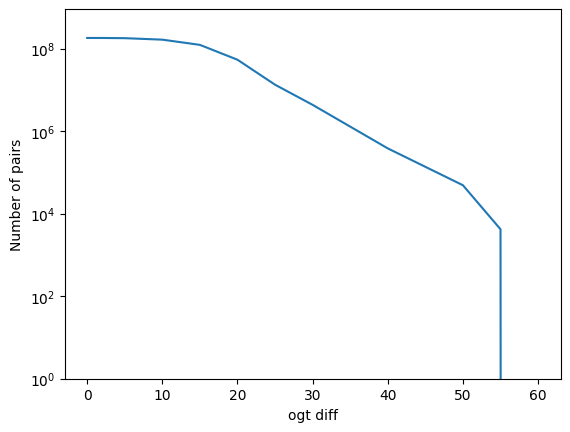

In [101]:
sns.lineplot(x = ogt_diffs, y = num_pairs)
plt.ylabel('Number of pairs')
plt.xlabel('ogt diff')
plt.yscale('log')
plt.ylim(1,num_pairs[0]*5);

In [ ]:
# Need to explore number of protein pairs per taxa pair for different ogt_diff values

### Summary
There are few samples with high ogt difference. We should include ogt_diff as a feature in our model and sample it selectively to provide enough examples of high-difference pairs.